# Billboard Data Genre Processing & Analysis

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

## Steps:

1. Load the processed csv into a dataframe

In [28]:
new_bb_df = pd.read_csv("../data/compressed/new_billboard_compressed.csv")


2. Get the genre whitelist

In [29]:
# to extract the genres from the 'Artist(s) Genres column
list_of_all_genres = (
    new_bb_df["Artist(s) Genres"]
    .dropna()
    .apply(lambda x: [g.strip() for g in x.split(",")])
)

# Flatten the list
all_genres = [genre for sublist in list_of_all_genres for genre in sublist]

# Get the unique genres
unique_genres = sorted(set(all_genres))

print("Number of unique genres:", len(unique_genres))


Number of unique genres: 1343


In [30]:
new_genres_whitelist = ["Alternative", "Blues", "Country", "Disco", "EDM", "Electronic", "Folk", "Funk",
                  "Hip Hop", "House", "Indie", "Jazz", "Metal", "Motown", "Pop", "R&B", "Rap", "Rock", "Soul"]

merge_map = {
    "EDM": "Electronic",
    "House": "Electronic",
    "Indie": "Alternative"
}

# lowercase mapping for easier substring search later
wl_map = {g.lower(): g for g in new_genres_whitelist}

def normalize_genres(genre_string):
    if pd.isna(genre_string):
        return ""

    genre_string = genre_string.lower()
    matched = []

    # check each whitelist genre
    for wl_key, wl_value in wl_map.items():
        if wl_key in genre_string:
            matched.append(wl_value)

    # do the merge map for the electronic and indie genre
    merged = []
    for g in matched:
        if g in merge_map:
            merged.append(merge_map[g])
        else:
            merged.append(g)
    

    # deduplicate but keep in the order
    merged = list(dict.fromkeys(merged))
    return ", ".join(merged)


new_bb_df["Cleaned Genres"] = new_bb_df["Artist(s) Genres"].apply(normalize_genres)

In [31]:
new_bb_df.tail()

,Artist(s) Genres,Hot100 Ranking Year,Hot100 Rank,Cleaned Genres
6288,"['modern country pop', 'contemporary country']",2022,96,"Country, Pop"
6289,"['chicago drill', 'chicago rap', 'new york dri...",2022,97,"Hip Hop, Rap"
6290,"['pop', 'transpop', 'alt z', 'uk pop']",2022,98,Pop
6291,"['country road', 'contemporary country', 'coun...",2022,99,Country
6292,"['classic texas country', 'contemporary country']",2022,100,Country


3. Get the weights of each song/it's genre based off of it's position on the chart and the year the chart was released.

In [ ]:
# assign weights based on the rank per year
def assign_weights(group):
    group = group.copy()
    group["Weight"] = 101 - group["Hot100 Rank"]
    return group

new_bb_df = new_bb_df.groupby("Hot100 Ranking Year").apply(assign_weights).reset_index(drop=True) 


# split the weights across genres and explode
new_bb_df["Genre List"] = new_bb_df["Cleaned Genres"].str.split(", ")
exploded_df = new_bb_df.explode("Genre List")
exploded_df = exploded_df[exploded_df["Genre List"].notna() & (exploded_df["Genre List"] != "")]
exploded_df["Weight Per Genre"] = exploded_df["Weight"] / exploded_df.groupby(["Hot100 Ranking Year", "Hot100 Rank"])["Genre List"].transform('count')


# aggregate the weights per genre per year
genre_year_weights = (
    exploded_df
    .groupby(["Hot100 Ranking Year", "Genre List"])["Weight Per Genre"]
    .sum()
    .reset_index()
    .sort_values(["Hot100 Ranking Year", "Weight Per Genre"], ascending=[True, False])
)

# display the genre weights per year in a pivot table
genre_year_matrix = genre_year_weights.pivot(
    index="Hot100 Ranking Year",
    columns="Genre List",
    values="Weight Per Genre"
).reset_index()

genre_year_matrix = genre_year_matrix.fillna(0)
genre_totals = genre_year_matrix.drop(columns=["Hot100 Ranking Year"]).sum().sort_values(ascending=False)
genre_year_matrix = genre_year_matrix[["Hot100 Ranking Year"] + genre_totals.index.tolist()]
display(genre_year_matrix)

genre_year_matrix.to_csv("../data/compressed/genre_year_weights.csv", index=False)

C:\Users\olivi\AppData\Local\Temp\ipykernel_22608\271814181.py:7: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  new_bb_df = new_bb_df.groupby("Hot100 Ranking Year").apply(assign_weights).reset_index(drop=True)


Genre List,Hot100 Ranking Year,Pop,Rock,R&B,Rap,Hip Hop,Soul,Country,Folk,Disco,Motown,Metal,Funk,Blues,Alternative,Electronic,Jazz
0,1960,754.000000,1637.500000,0.000000,0.000000,0.000000,205.000000,59.500000,198.500000,0.000000,95.000000,0.00,0.000000,366.500000,0.000000,0.000000,122.000000
1,1961,419.666667,1192.666667,0.000000,27.000000,0.000000,563.333333,134.000000,107.166667,12.000000,89.666667,0.00,50.666667,775.833333,0.000000,0.000000,75.000000
2,1962,654.833333,1406.666667,0.000000,0.000000,0.000000,589.166667,62.000000,117.833333,0.000000,210.166667,0.00,39.500000,441.166667,12.000000,0.000000,430.666667
3,1963,725.333333,816.833333,0.000000,0.000000,0.000000,632.333333,25.000000,289.166667,0.000000,232.500000,0.00,8.000000,539.000000,0.000000,0.000000,132.833333
4,1964,650.266667,1459.266667,0.000000,0.000000,0.000000,638.766667,107.500000,250.000000,86.266667,225.000000,0.00,22.500000,164.833333,0.000000,0.000000,325.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,2018,2089.250000,196.000000,167.500000,1122.416667,666.916667,22.666667,248.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,125.916667,142.333333,0.000000
59,2019,2216.600000,108.333333,199.350000,1279.183333,513.600000,1.600000,389.666667,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,160.000000,150.666667,0.000000
60,2020,2174.683333,83.600000,157.166667,1302.016667,571.166667,40.000000,524.750000,0.000000,0.000000,0.000000,11.60,0.000000,0.000000,29.600000,68.416667,0.000000
61,2021,1881.033333,226.450000,265.666667,1084.616667,718.533333,23.500000,449.200000,0.000000,0.000000,0.000000,3.75,0.000000,0.000000,112.250000,19.000000,0.000000


4. Create the visualizaiton for the data (multi-line plot)

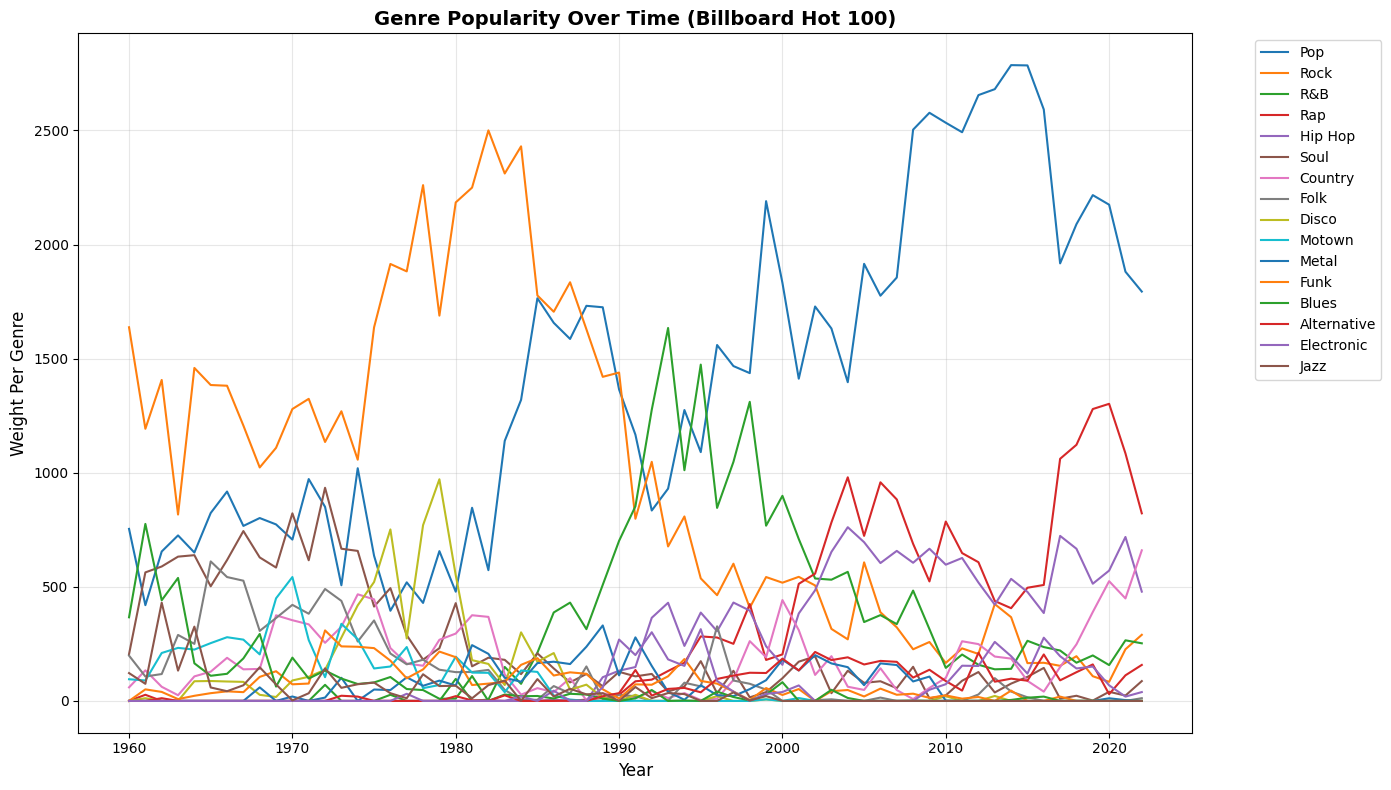

In [33]:
plt.figure(figsize=(14, 8))

for genre in genre_totals.index:
    plt.plot(genre_year_matrix['Hot100 Ranking Year'], 
             genre_year_matrix[genre], 
             label=genre,
             )

plt.title('Genre Popularity Over Time (Billboard Hot 100)', fontsize=14, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Weight Per Genre', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Analysis:

### Trends and Findings + Visual References
Our pivot table and visualization graph reveals clear long-term genre cycles across the Billboard Hot 100, highlighting major cultural shifts in American music. Below is a summery of the most significant patterns that I found:

#### 1. 1960s: Rock Dominance + Rise of Soul/Motown
In the multi-line plot, Rock appears as one of highest and most stable lines from the early 60s up until the mid-80s. Soul and Motown also show noticable upward slopes starting around the mid-60s, forming a small cluster of rusing lines right below Rock. Folk also showed a brief spike in the early 60s before flattening again in a couple years. This entire period had a diverse but Rock-centered landscape.

#### 2. 1970s: Clear Spike and Crash of Disco
One of the more dramatic patterns in the entire figure is the sharp rise and fall of Disco music, forming two steep upward lines, with its highest peak being in the late 70s. They create two peak shapes in the plot that accurately match the real-world boom and collapse of disco music

#### 3. Late 70s - Early 80s: The Resurgence & Peak of Rock Music & Early Pop Growth
After Disco begins to decline, the Rock line (which was still previously dominant) rises again even higher than before to reach its peak in the mid-80s. Pop music also begins showing consistent upward movement to become the second-most dominant genre right after Rock.

#### 4. Mid-Late 80s: The Beginning of Rap & Hip-Hop & Sharp Decline of Rock
Though they are still below Rock and Pop, this is the time period where Rap and Hip-Hop begin to show an upward trend and become visually noticable in the graph, marking the beginning of their entrance into the mainstream charts. We also begin to see the major decline of Rock music during this time period as the Rock line dramatically declines downward for the first time in two decades.

#### 5. 1990s: The Rise of R&B, Rap and Hip-Hop
This portion of the multi-line plot shows a major shift in which lines dominate the upper region of the figure. Rap, Hip-Hop and R&B all increase sharply, with their lines consistently trending upwards throught this decade. Electronic music also starts to move upward consistently throughout this period and becomes quite popular. The Rock line continues to trend downward significantly. This cluster of upward trending lines makes the 90s the most visually distinct section of the plot, and is notably the only time where there is no clear dominating genre unlike the previous decades where one genre clearly dominated all others.

#### 6. 2000s: Pop Dominance + Continued Rap, Hip-Hop & Electronic Strength
During this decade, Pop becomes one of the strongest and most stable high-level lines, accurately reflecting the large popularity of pop music during this time period. Hip-hop and Rap still remain strong, showing either stable or increasing weights. Electronic music also shows another rise, reflecting the EDM crossover that peaked in the late 2000s to early 2010s.

#### 7. 2010s: Reign of Pop, Stability of Rap & Hip-Hop and the Rise of Country
The Pop continues to rise even higher during this decade, with the rap and hip-hop lines also demonstrating and increase during the mid-2010s. We can also observe a steady decline in the Electronic line and a small but steady rise in Country music during the mid-2010s.


# 